# <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">تراز سازی سند اسکن شده</div>


### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">در این پروژه مباحث زیر مرور میگردد:</div>

* **Morphology:**
    [22-Dilation-erosion-opening-and-closing.ipynb](https://nbviewer.org/github/Alireza-Akhavan/class.vision/blob/master/22-Dilation-erosion-opening-and-closing.ipynb)
    
* **Grabcut:** [73-Grabcut.ipynb](https://nbviewer.org/github/Alireza-Akhavan/class.vision/blob/master/73-Grabcut.ipynb)
* **Canny Edge Detection:**
    [51-Canny-edge-detector.ipynb](https://nbviewer.org/github/Alireza-Akhavan/class.vision/blob/master/51-Canny-edge-detector.ipynb)
* **Contours:** [26-Finding_contours.ipynb](https://nbviewer.org/github/Alireza-Akhavan/class.vision/blob/master/26-Finding_contours.ipynb)
* **Douglas-Peucker algorithm:** [30-ApproxPolyDP.ipynb](https://nbviewer.org/github/Alireza-Akhavan/class.vision/blob/master/30-ApproxPolyDP.ipynb)
* **Homography and Perspective TransformPerspective Transform:** [64-Perspective-transformation.ipynb](https://nbviewer.org/github/Alireza-Akhavan/class.vision/blob/master/64-Perspective-transformation.ipynb)


### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">لود کتابخانه های مورد نیاز:</div>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">تصویر ورودی:</div>

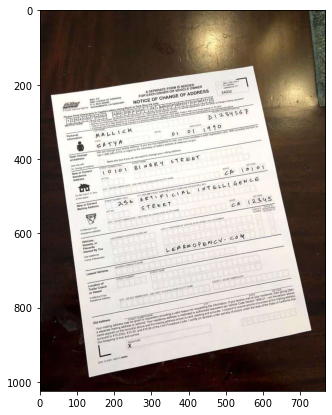

In [2]:
img = cv2.imread('images/form.jpg')

plt.figure(figsize=[15,7])
plt.imshow(img[...,::-1]);

### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">اعمال محدودیت روی سایز تصویر:</div>
<div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">حداکثر طول یا عرض تصویر را 1080 قرار داده ایم!</div>

In [3]:
# Resize image to workable size
dim_limit = 1080
max_dim = max(img.shape)
if max_dim > dim_limit:
    resize_scale = dim_limit / max_dim
    img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)

# Making Copy of original image.
orig_img = img.copy()

### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">عملیات مروفولوژی روی تصویر اسکن شده:</div>

In [4]:
# Repeated Closing operation to remove text from the document.
kernel = np.ones((5,5),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations= 3)

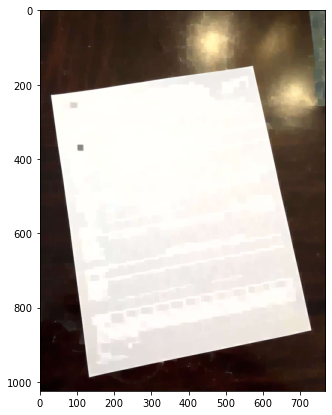

In [5]:
plt.figure(figsize = (10,7))
plt.imshow(img[:,:,::-1])
plt.show()

### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">استفاده از Grabcut برای بریدن تقریبی ناحیه ی تصویر:</div>

In [6]:
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (20,20,img.shape[1]-20,img.shape[0]-20)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

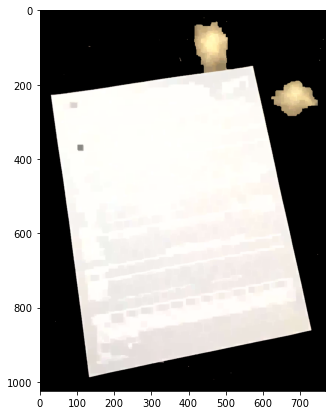

In [7]:
plt.figure(figsize = (10,7))
plt.imshow(img[:,:,::-1])
plt.show()

### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">استخراج لبه و کانتور:</div>

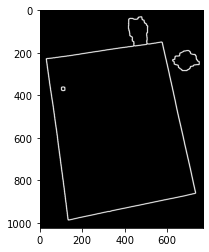

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge Detection.
canny = cv2.Canny(gray, 100, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
plt.imshow(canny, cmap='gray')

In [9]:
# Blank canvas.
con = np.zeros_like(img)
# Finding contours for the detected edges.
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the largest detected contour.
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)

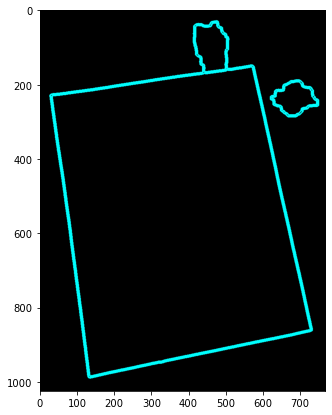

In [10]:
plt.figure(figsize = (10,7))
plt.imshow(con)
plt.show()

### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">پیدا کردن گوشه ها با الگوریتم ApproxPolyDP:</div>


In [14]:
def order_points(pts):
    '''Rearrange coordinates to order: 
       top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()

[[32, 231], [568, 152], [726, 858], [135, 984]]


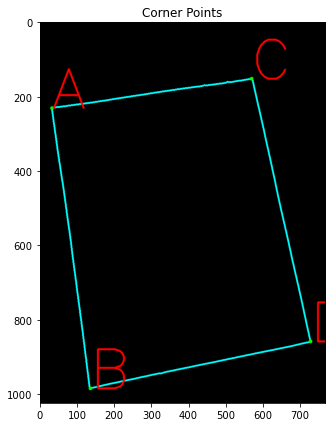

In [15]:
# Blank canvas.
con = np.zeros_like(img)
# Loop over the contours.
for c in page:
    # Approximate the contour.
    epsilon = 0.02 * cv2.arcLength(c, True)
    corners = cv2.approxPolyDP(c, epsilon, True)
    # If our approximated contour has four points
    if len(corners) == 4:
        break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# Sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())

# Displaying the corners.
for index, c in enumerate(corners):
    character = chr(65 + index)
    cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 3, cv2.LINE_AA)

# Rearranging the order of the corner points.
corners = order_points(corners)

print(corners)

plt.figure(figsize = (10,7))
plt.imshow(con)
plt.title('Corner Points')
plt.show()

### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">محاسبه ی ابعاد مستطیل نهایی!</div>


In [16]:
(tl, tr, br, bl) = corners
# Finding the maximum width.
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))

# Finding the maximum height.
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
# Final destination co-ordinates.
destination_corners = [
        [0, 0],
        [maxWidth, 0],
        [maxWidth, maxHeight],
        [0, maxHeight]]
print(destination_corners)

[[0, 0], [604, 0], [604, 760], [0, 760]]


### <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">اعمال Homography و Perspective Transform:</div>

# 

In [17]:
# Getting the homography.
homography = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
# Perspective transform using homography.
final = cv2.warpPerspective(orig_img, np.float32(homography), (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
# cv2.imwrite('grabcutop/img22.jpg', final)

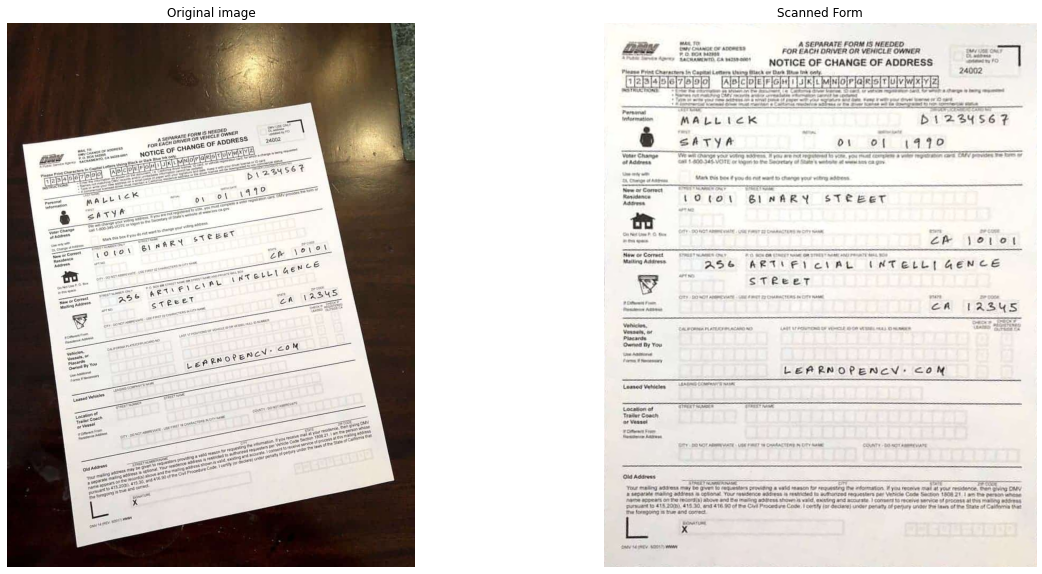

In [18]:
# Display results 
plt.figure(figsize=[20,10]); 
plt.subplot(121); plt.imshow(orig_img[:,:,::-1]); plt.axis('off'); plt.title("Original image")
plt.subplot(122); plt.imshow(final[:,:,::-1]); plt.axis('off'); plt.title("Scanned Form");

Source: https://learnopencv.com/automatic-document-scanner-using-opencv/